# Выпускной проект. Промышленность.

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали.

ЗАДАЧА: создать модель, которая предскажет температуру стали. (MAE < 6)

ЭТАПЫ ОБРАБОТКИ СТАЛИ:

1. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. data_arc.csv.

2. Из сплава выводится сера (десульфарация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют ее состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат. data_bulk.csv, data_bulk_time.csv.

3. Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и проводят ее химический анализ. Потом на несколько минут температуру повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводя измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки. data_temp.csv, data_gas.csv

4. Расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов. data_wire.csv, data_wire_time.csv

ОПИСАНИЕ ДАННЫХ

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

   # ПЛАН
1. Знакомство с задачей: что нужно сделать, какие этапы в процессе обработки существуют.
2. Импорт библиотек.
3. Знакомство с данными: какие есть таблицы, столбцы, что нам понадобится (ячейки 2-16).
4. Предварительная обработка: пропуски, выбросы. Объединение всех нужных сведений в одну таблицу (ячейки 17-60).
5. Обучение и кросс-валидация моделей (ячейки 61-64).
6. Визуализация результатов (ячейки 65-69).

In [ ]:
#импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import lightgbm as lgbm
import xgboost as xg
from catboost import CatBoostRegressor
from sklearn.inspection import permutation_importance
import warnings
warnings.simplefilter("ignore", UserWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [ ]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [ ]:
display(data_arc.head())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [ ]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [ ]:
display(data_bulk.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [ ]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [ ]:
display(data_bulk_time.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [ ]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [ ]:
display(data_gas.head())

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [ ]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [ ]:
display(data_temp.head())

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [ ]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [ ]:
display(data_wire.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [ ]:
display(data_wire_time.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Предобработка данных.


Справочно: для работы с графитовыми электродами нужен постоянный ток. 
Активная мощность характеризует энергию, расходуемую источником на производство полезной работы потребителем.
Поэтому из указанной таблицы возьмем сведения о длительности нагрева каждой партии и среднюю активную мощность.

In [ ]:
#изменим тип данных на datetime64
data_arc['Начало нагрева дугой']= pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой']= pd.to_datetime(data_arc['Конец нагрева дугой'])

In [ ]:
data_arc['Промежуток'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']

In [ ]:
agg_func_math = {
    'Промежуток': ['sum']
}
data_electrode_heating_sum = data_arc.groupby(['key']).agg(agg_func_math)
display(data_electrode_heating_sum)

,Промежуток
,sum
key,
1,0 days 00:18:18
2,0 days 00:13:31
3,0 days 00:10:55
4,0 days 00:12:21
5,0 days 00:14:29
...,...
3237,0 days 00:15:09
3238,0 days 00:09:06


In [ ]:
data_electrode_heating_sum.columns = ['electrode_heating_sum'] #назовем столбец

In [ ]:
#посчитаем длительность нагрева в секундах
data_electrode_heating_sum['electrode_heating_sum'] = data_electrode_heating_sum['electrode_heating_sum'].dt.total_seconds()

In [ ]:
agg_func_math = {
    'Активная мощность': ['mean']
}
data_energy = data_arc.groupby(['key']).agg(agg_func_math)
display(data_energy)

,Активная мощность
,mean
key,
1,0.975629
2,0.763150
3,0.505176
4,0.802313
5,0.836793
...,...
3237,0.786493
3238,0.702176


In [ ]:
#объединим то, что получилось
df_arc = data_electrode_heating_sum.merge(data_energy, on='key', how='outer')

In [ ]:
df_arc.columns = ['electrode_heating_sum', 'energy_mean']

In [ ]:
#посчитаем пропуски
data_temp.isna().sum()

key                0
Время замера       0
Температура     2901
dtype: int64

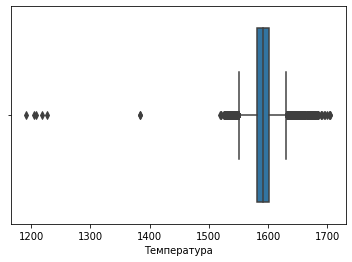

In [ ]:
#посмотрим на выбросы
df_temp = sns.boxplot(x=data_temp["Температура"])

Есть выбивающиеся значения, которые достаточно далеки от температуры плавления стали (1400 С), но на данном этапе я пока ничего с ними не делаю.

In [ ]:
#изменим тип данных
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [ ]:
#посчитаем промежуток между первым и последним замером температуры
data_temp["Длительность"] = \
    (data_temp
     .groupby("key")
     ["Время замера"]
     .transform(lambda x: x.max() - x.min()))

In [ ]:
#оставим 1 строку для каждой партии
agg_func_math = {
    'Длительность': ['first']
}
data_dur = data_temp.groupby(['key']).agg(agg_func_math)
display(data_dur)

,Длительность
,first
key,
1,0 days 00:14:21
2,0 days 00:21:45
3,0 days 00:21:40
4,0 days 00:06:28
5,0 days 00:12:42
...,...
3237,0 days 00:21:39
3238,0 days 00:12:29


In [ ]:
#назовем столбец
data_dur.columns = ['duration']

In [ ]:
#посчитаем время в секндах
data_dur['duration'] = data_dur['duration'].dt.total_seconds()

In [ ]:
#избавимся от отсутствующих значений
data_temp_full = data_temp.dropna()

In [ ]:
data_temp_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   key           13006 non-null  int64          
 1   Время замера  13006 non-null  datetime64[ns] 
 2   Температура   13006 non-null  float64        
 3   Длительность  13006 non-null  timedelta64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), timedelta64[ns](1)
memory usage: 508.0 KB


In [ ]:
#посмотрим на последнее время замера
agg_func_math = {
    'Время замера': ['max']
}
data_temp_max = data_temp_full.groupby(['key']).agg(agg_func_math)
display(data_temp_max)

,Время замера
,max
key,
1,2019-05-03 11:30:39
2,2019-05-03 11:59:12
3,2019-05-03 12:34:57
4,2019-05-03 12:59:25
5,2019-05-03 13:36:01
...,...
3237,2019-08-31 22:44:04
3238,2019-08-31 23:30:31


In [ ]:
#выберем первую и последнюю температуру
agg_func_math = {
    'Температура': ['first', 'last']
}
data_temp_last = data_temp_full.groupby(['key']).agg(agg_func_math)
display(data_temp_last)

Температура        
           first    last
key                     
1         1571.0  1613.0
2         1581.0  1602.0
3         1596.0  1599.0
4         1601.0  1625.0
5         1576.0  1602.0
...          ...     ...
3237      1569.0  1569.0
3238      1584.0  1584.0
3239      1598.0  1598.0
3240      1617.0  1617.0
3241      1586.0  1586.0

[3216 rows x 2 columns]

In [ ]:
#назовем столбцы
data_temp_max.columns = ['data_temp_max']
data_temp_last.columns = ['data_temp_first', 'data_temp_last']

In [ ]:
#объединим таблицы
data_temp_complete = data_temp_max.merge(data_temp_last, on=['key'], how='outer')

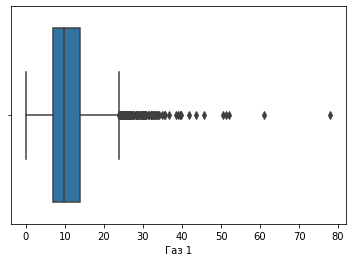

In [ ]:
data_gas_box = sns.boxplot(x=data_gas['Газ 1'])

Есть выбросы, думаю, избавиться от значений больше 25.

In [ ]:
data_gas = data_gas[(data_gas['Газ 1'] < 25)]

In [ ]:
data_gas.columns = ['key', 'gas'] #назовем столбцы, чтобы все было в едином стиле

In [ ]:
#посчитаем суммарный объем добавок к каждой партии
data_bulk_sum = data_bulk[['key']].join(data_bulk.drop('key', 1).sum(axis=1).rename('sum'))

In [ ]:
data_bulk_sum.columns = ['key','data_bulk_sum'] #назовем столбцы

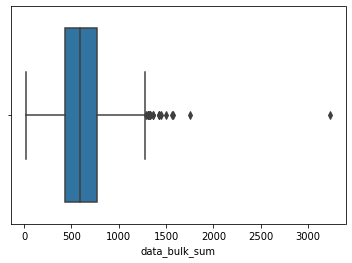

In [ ]:
data_bulks = sns.boxplot(x=data_bulk_sum['data_bulk_sum'])

Как следует из диаграммы, выбросы составляют значения больше 1300

In [ ]:
data_bulk_sum = data_bulk_sum[(data_bulk_sum['data_bulk_sum'] < 1300)]

In [ ]:
#посчитаем суммарный объем проволочных материалов для каждой партии
data_wire_sum = data_wire[['key']].join(data_wire.drop('key', 1).sum(axis=1).rename('sum'))

In [ ]:
data_wire_sum.columns = ['key','data_wire_sum'] 

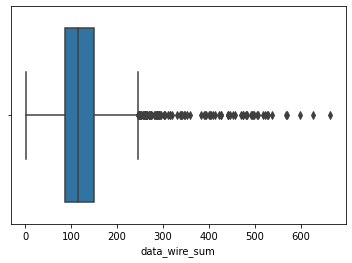

In [ ]:
data_wires = sns.boxplot(x=data_wire_sum['data_wire_sum'])

Отбросим значения больше 300.

In [ ]:
data_wire_sum = data_wire_sum[(data_wire_sum['data_wire_sum'] < 300)]

In [ ]:
#объединим таблицы
data_bulk_wire = data_bulk_sum.merge(data_wire_sum, on=['key'], how='outer').reset_index(drop=True)

In [ ]:
data_complete = data_bulk_wire.merge(data_gas, on=['key'], how='outer').reset_index(drop=True)

In [ ]:
df_comp= data_complete.merge(data_dur, on='key', how='outer').reset_index(drop=True)

In [ ]:
df_0 = df_comp.merge(data_temp_complete, on=['key'], how='outer').reset_index(drop=True)

In [ ]:
#удалим значения, в которых первая температура - это последняя температура
df_dropped = df_0[(df_0['data_temp_first'] != df_0['data_temp_last'])].reset_index(drop=True)

df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2458 entries, 0 to 2457
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   key              2458 non-null   int64         
 1   data_bulk_sum    2345 non-null   float64       
 2   data_wire_sum    2294 non-null   float64       
 3   gas              2370 non-null   float64       
 4   duration         2433 non-null   float64       
 5   data_temp_max    2433 non-null   datetime64[ns]
 6   data_temp_first  2433 non-null   float64       
 7   data_temp_last   2433 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 153.8 KB


In [ ]:
df_1=df_dropped.drop(['data_temp_max'], axis=1)

In [ ]:
df_2=df_1.merge(df_arc, on='key', how='outer')

In [ ]:
#после всех объединений избавимся от пропусков
df=df_2.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 1 to 2344
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2155 non-null   int64  
 1   data_bulk_sum          2155 non-null   float64
 2   data_wire_sum          2155 non-null   float64
 3   gas                    2155 non-null   float64
 4   duration               2155 non-null   float64
 5   data_temp_first        2155 non-null   float64
 6   data_temp_last         2155 non-null   float64
 7   electrode_heating_sum  2155 non-null   float64
 8   energy_mean            2155 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 168.4 KB


In [ ]:
df=df.drop(['key'], axis=1)

In [ ]:
df.describe()

,data_bulk_sum,data_wire_sum,gas,duration,data_temp_first,data_temp_last,electrode_heating_sum,energy_mean
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,599.730394,119.039951,10.538794,1806.611601,1586.373086,1593.276102,789.828306,0.666448
std,271.402373,49.762035,4.828511,1015.727547,28.436314,10.897188,317.555429,0.196811
min,19.000000,1.918800,0.008399,234.000000,1191.000000,1545.000000,57.000000,0.186226
25%,440.000000,87.172801,7.154428,1196.500000,1571.000000,1587.000000,573.000000,0.523828
50%,607.000000,114.368799,9.857191,1589.000000,1586.000000,1593.000000,767.000000,0.640897
75%,781.500000,149.149515,13.499086,2225.000000,1603.000000,1598.000000,973.000000,0.788870
max,1290.000000,295.364159,24.989361,16669.000000,1660.000000,1653.000000,2919.000000,1.421416


In [ ]:
#используем IQR метод, чтобы избавиться от выбросов. Т.К. data_temp_last у нас является целевым признаком, 
#будем отталкиваться от значений именно этого столбца, чтобы исключить выбросы
IQR = 1598-1587
upper_bound=(1.5*IQR)+1598
lower_bound=1587-(1.5*IQR)
print(upper_bound)
print(lower_bound)

1614.5
1570.5


In [ ]:
dfs= df[(df['data_temp_last']< upper_bound)&(df['data_temp_last']>lower_bound)]
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2001 entries, 1 to 2344
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   data_bulk_sum          2001 non-null   float64
 1   data_wire_sum          2001 non-null   float64
 2   gas                    2001 non-null   float64
 3   duration               2001 non-null   float64
 4   data_temp_first        2001 non-null   float64
 5   data_temp_last         2001 non-null   float64
 6   electrode_heating_sum  2001 non-null   float64
 7   energy_mean            2001 non-null   float64
dtypes: float64(8)
memory usage: 140.7 KB


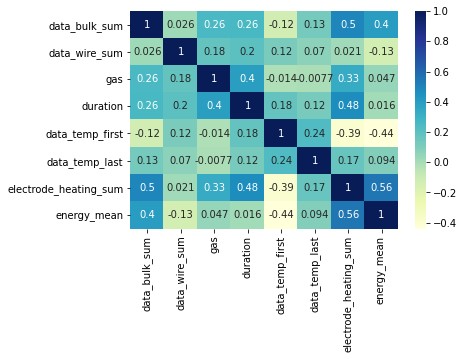

In [ ]:
#посмотрим на корреляцию
dataplot=sns.heatmap(dfs.corr(), cmap="YlGnBu", annot=True)

Есть несколько столбцов с умеренной прямой и непрямой корреляцией.

# Создание и обучение моделей

In [ ]:
dfs.head(3)

,data_bulk_sum,data_wire_sum,gas,duration,data_temp_first,data_temp_last,electrode_heating_sum,energy_mean
1,582.0,96.052315,12.555561,1305.0,1581.0,1602.0,811.0,0.763150
4,584.0,98.352796,5.413692,762.0,1576.0,1602.0,869.0,0.836793
5,676.0,108.224477,11.273392,1385.0,1543.0,1596.0,952.0,0.988777


In [ ]:
#обозначим целевой признак
features = dfs.drop('data_temp_last', axis=1)
target = dfs['data_temp_last']

In [ ]:
#отмасштабируем признаки
numeric = ['data_bulk_sum', 'data_wire_sum', 'gas', 'duration', 'energy_mean', 'electrode_heating_sum', 'data_temp_first']
scaler = StandardScaler()
scaler.fit(features[numeric]) 
features[numeric] = scaler.transform(features[numeric])

In [ ]:
#обучим модели и проведем кросс-валидацию
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), 
          xg.XGBRFRegressor(), lgbm.LGBMRegressor(), GradientBoostingRegressor(), CatBoostRegressor(verbose=False)]
for model in models:
    scoring = 'neg_mean_absolute_error'
    mae = cross_val_score(model, features, target, cv=5,scoring=scoring)
    score = mae.max()
    final_scores = score*(-1)
    print(type(model).__name__)
    print("    MAE", (round(final_scores, 2)))
    print()

LinearRegression
    MAE 5.51

DecisionTreeRegressor
    MAE 7.06

RandomForestRegressor
    MAE 5.18

XGBRFRegressor
    MAE 5.37

LGBMRegressor
    MAE 5.2

GradientBoostingRegressor
    MAE 5.15

CatBoostRegressor
    MAE 5.14



In [ ]:
model_catboost = CatBoostRegressor(verbose=False)
predictions_catboost = cross_val_predict(model_catboost, features, target, cv=5)

Text(0.5, 1.0, 'Permutation Importance')

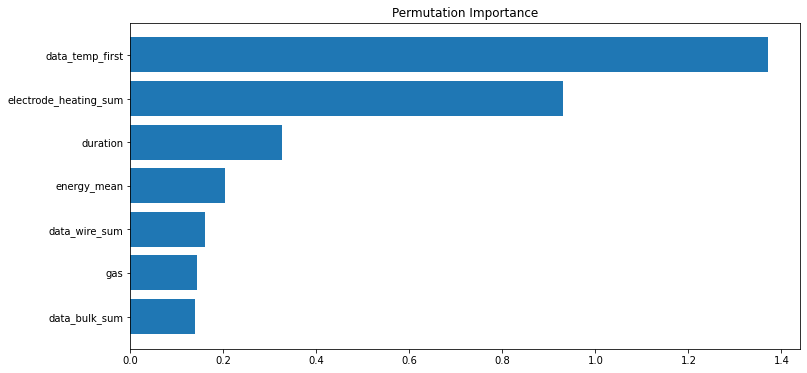

In [ ]:
model_catboost.fit(features, target)
perm_importance = permutation_importance(model_catboost, features, target, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features.columns)[sorted_idx])
plt.title('Permutation Importance')


Как видно из графика, очень большое влияние у начальной температуры и суммарного времени нагрева электродами.

In [ ]:
#добавим столбцы с предсказаниями лучшей модели
dfs['catboost'] = predictions_catboost

In [ ]:
#сделаем новую таблицу
df_final = dfs[['data_temp_last', 'catboost']]

In [ ]:
display(df_final)

,data_temp_last,catboost
1,1602.0,1596.343304
4,1602.0,1594.097808
5,1596.0,1585.974242
6,1599.0,1595.128960
7,1598.0,1593.188785
...,...,...
2340,1591.0,1593.352259
2341,1591.0,1588.471215
2342,1589.0,1590.541379
2343,1594.0,1598.218911


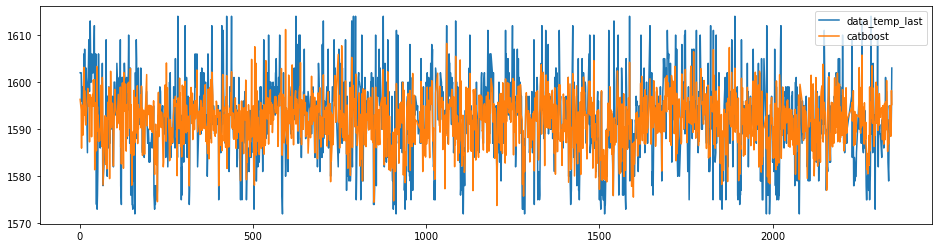

In [ ]:
#посмотрим 
df_final[['data_temp_last', 'catboost']].plot(figsize=(16,4))
plt.show()

# Вывод

1. Были изучены имеющиеся данные, произведен их анализ, обработка, удалены выбивающиеся значения и пропуски; выбраны те данные, которые помогут решить поставленную задачу, т.е. предсказать температуру стали.


2. Данные собраны в единую таблицу. Проведена обработка методом IQR в отношении целевого признака - последней замеренной температуры. *Справочно: если не проводить анализ на выбросы и не удалять выбивающиеся значения вообще, оставив только метод IQR, все модели показывают результат меньше 6, кроме DecisionTreeRegressor, но больше 5.19).*


3. Данные подготовлены для проведения кросс-валидации, определен целевой признак, проведено масштабирование.


4. Обучены и проверены кросс-валидацией несколько моделей регресии (LinearRegression, DecisionTreeRegressor, RandomForestRegressor, XGBRFRegressor, LGBMRegressor, GradientBoostingRegressor, CatBoostRegressor).


5. Среднюю абсолютную ошибку меньше 6 показывают все модели, кроме DecisionTreeRegressor.


6. Выбран наилучший результат для визуализации (CatBoostRegressor).